In [1]:
from dataset_creation import *
from dataset_labels import *

In [ ]:
def get_edge_subset_mask(edge_index_big, edge_index_small):
    small_set = set(zip(edge_index_small[0].tolist(), edge_index_small[1].tolist()))
    mask = [
        (u.item(), v.item()) in small_set
        for u, v in zip(edge_index_big[0], edge_index_big[1])
    ]
    return torch.tensor(mask, dtype=torch.int)

def new_round(x, th):
    rounded_values = torch.where(
        x - x.floor() + 0.000001 >= th, x.ceil(), x.floor())
    return rounded_values.int()

In [2]:
dataset = Dataset_1_orig(root="data/Dataset1", pre_transform=None)
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

In [3]:
#plot a directed graph given edge_index with root node colored with different color
def plot_graph(data):
    import networkx as nx
    import matplotlib.pyplot as plt
    from torch_geometric.utils import to_networkx

    G = to_networkx(data, to_undirected=False)

    pos = nx.planar_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True)
    
    # Highlight the root node
    #nx.draw_networkx_nodes(G, pos, nodelist=[root_node], node_color='red')
    
    plt.show()

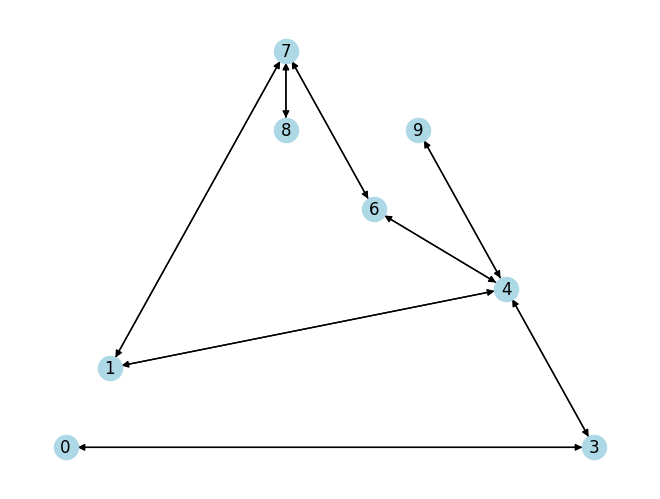

In [15]:
plot_graph(train_dataset[0])

In [71]:
edge_index = train_dataset[0].edge_index
num_nodes = max(edge_index.flatten() + 1)
ind = 4
nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(ind, 2, edge_index, False, num_nodes)
edge_attr_ = None
edge_list = edge_index_.T.tolist()
node_dict = {}
for node in range(num_nodes):
    if node in edge_index_[0]:
        if [node, ind] in edge_list or [node, ind] in edge_list or ind==node:
            node_dict[node] = 1
        else:
            node_dict[node] = 2
    else:
        node_dict[node] = 0
directed_edges = edge_index_
directed_edges = directed_edges[:, directed_edges[1] != ind]
#features_input = torch.ones(num_nodes)
#keep features of nodes as per the node_dict
features_input = torch.tensor([node_dict[n] for n in range(num_nodes)])
#features_input[ind] = 0
data_input = Data(x=features_input.unsqueeze(1), edge_index=directed_edges, num_nodes=num_nodes)

edge_index_ = directed_edges.T
new_edge_index = torch.tensor([], dtype=torch.long)
for edge in edge_index_:
    if edge[0] != ind and edge[1] != ind:
        new_edge_index = torch.cat(
            (new_edge_index, edge.unsqueeze(0)), dim=0)
edge_index_ = new_edge_index.T
if len(edge_index_.shape) == 1:
    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
data_label = Data(edge_index=edge_index_, num_nodes=num_nodes)
data_input.edge_mask = get_edge_subset_mask(
    data_input.edge_index, data_label.edge_index)


In [72]:
data_label

Data(edge_index=[2, 6], num_nodes=10)

In [73]:
node_dict

{0: 2, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 2, 8: 0, 9: 1}

In [74]:
features_input

tensor([2, 1, 0, 1, 1, 0, 1, 2, 0, 1])

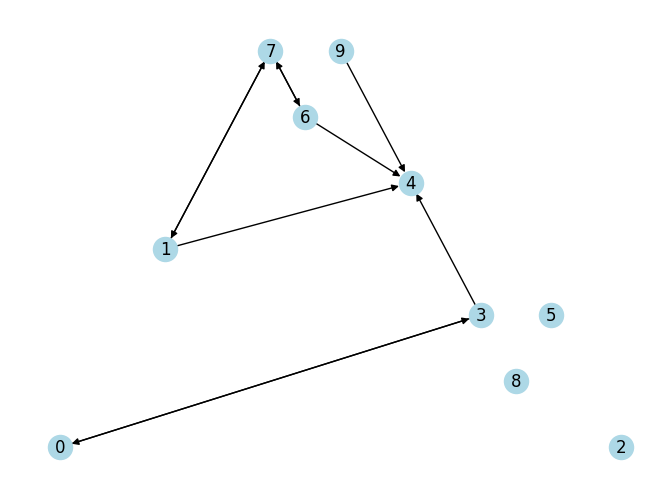

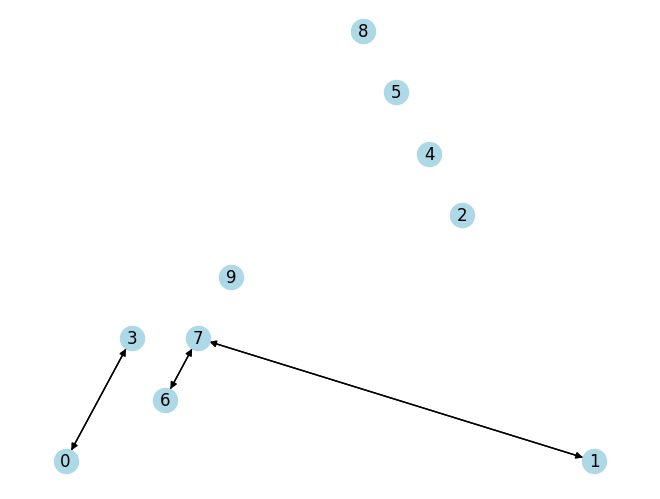

(None, None)

In [37]:
plot_graph(data_input), plot_graph(data_label)

In [66]:
class collater():
    def __init__(self, task):
        self.task = task
    
    def create_subgraphs(self, data):
        edge_index = data.edge_index
        num_nodes = max(data.edge_index.flatten() + 1)
        if is_undirected(edge_index):
            edge_index = to_undirected(edge_index)
        if contains_self_loops(edge_index):
            edge_index = remove_self_loops(edge_index)[0]
        subgraphs = []
        for ind in range(num_nodes):
            if self.task == "neighbors_2_neighbors_hop_1":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                directed_edges = edge_index_
                directed_edges = directed_edges[:, directed_edges[1] != ind]
                node_dict = {}
                for node in range(num_nodes):
                    if node in edge_index_[0]:
                        node_dict[node] = 1
                    else:
                        node_dict[node] = 0
                features_input = torch.tensor([node_dict[n] for n in range(num_nodes)])
                #features_input[ind] = 0
                data_input = Data(x=features_input.unsqueeze(1), edge_index=directed_edges, num_nodes=num_nodes)
                edge_index_ = directed_edges.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] != ind and edge[1] != ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                data_label = Data(edge_index=edge_index_, num_nodes=num_nodes)
                
                data_input.edge_mask = get_edge_subset_mask(
                    data_input.edge_index, data_label.edge_index)
                
            
            if self.task == "root_2_neighbors_hop_1":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                directed_edges = edge_index_
                directed_edges = directed_edges[:, directed_edges[1] != ind]
                node_dict = {}
                for node in range(num_nodes):
                    if node in edge_index_[0]:
                        node_dict[node] = 1
                    else:
                        node_dict[node] = 0
                features_input = torch.tensor([node_dict[n] for n in range(num_nodes)])
                #features_input[ind] = 0
                data_input = Data(x=features_input.unsqueeze(1), edge_index=directed_edges, num_nodes=num_nodes)
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] == ind or edge[1] == ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                data_label = Data(edge_index=edge_index_, num_nodes=num_nodes)

                data_input.edge_mask = get_edge_subset_mask(
                    data_input.edge_index, data_label.edge_index)
                
            if self.task == "neighbors_2_neighbors_hop_2":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(ind, 2, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_list = edge_index_.T.tolist()
                node_dict = {}
                for node in range(num_nodes):
                    if node in edge_index_[0]:
                        if [node, ind] in edge_list or [node, ind] in edge_list or ind==node:
                            node_dict[node] = 1
                        else:
                            node_dict[node] = 2
                    else:
                        node_dict[node] = 0
                directed_edges = edge_index_
                directed_edges = directed_edges[:, directed_edges[1] != ind]
                #features_input = torch.ones(num_nodes)
                #keep features of nodes as per the node_dict
                features_input = torch.tensor([node_dict[n] for n in range(num_nodes)])
                #features_input[ind] = 0
                data_input = Data(x=features_input.unsqueeze(1), edge_index=directed_edges, num_nodes=num_nodes)

                edge_index_ = directed_edges.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] != ind and edge[1] != ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                data_label = Data(edge_index=edge_index_, num_nodes=num_nodes)
                data_input.edge_mask = get_edge_subset_mask(
                    data_input.edge_index, data_label.edge_index)

            subgraphs.append((data_input, data_label))
        return subgraphs
    
    def __call__(self, batch):
        all_subgraphs = []
        for graph in batch:
            subgraphs = self.create_subgraphs(graph)
            all_subgraphs.extend(subgraphs)
        return all_subgraphs

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv

class EdgePruningModel(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_layers):
        super().__init__()
        self.conv = torch.nn.ModuleList()
        self.conv.append(GINConv(torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()), train_eps=False))
        for i in range(num_layers - 1):
            self.conv.append(GINConv(torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()), train_eps=False))
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, edge_index):
        for i in range(len(self.conv)):
            x = self.conv[i](x, edge_index)
            x = F.relu(x)

        src, dst = edge_index
        edge_feat = torch.cat([x[src], x[dst]], dim=1)

        edge_logits = self.edge_mlp(edge_feat).squeeze()
        edge_probs = torch.sigmoid(edge_logits)
        return edge_probs  


In [75]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgePruningModel(in_channels=1, hidden_dim=16, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.BCELoss()
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collater(task="neighbors_2_neighbors_hop_2"))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collater(task="neighbors_2_neighbors_hop_2"))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collater(task="neighbors_2_neighbors_hop_2"))
def train(train_loader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    avg_acc = 0
    num_sample = 0
    for data in tqdm(train_loader):
        data = data[0][0].to(device)
        if data.edge_index.size()[-1]==0:
            continue
        else:
            optimizer.zero_grad()
            edge_probs = model(data.x, data.edge_index)
            if edge_probs.shape != data.edge_mask.shape:
                edge_probs = edge_probs.reshape(data.edge_mask.shape)
            loss_value = loss_fn(edge_probs, data.edge_mask.float())
            loss_value.backward()
            optimizer.step()
            pred_edge = new_round(edge_probs, 0.9)
            acc = (pred_edge == data.edge_mask).float().mean()
            total_loss += loss_value.item()
            avg_acc += acc.item()
            num_sample += 1
    return total_loss / num_sample, avg_acc / num_sample

def evaluate(loader, model, loss_fn):
    model.eval()
    total_loss = 0
    avg_acc = 0
    num_sample = 0
    with torch.no_grad():
        for data in tqdm(loader):
            data = data[0][0].to(device)
            if data.edge_index.size()[-1]==0:
                continue
            else:
                edge_probs = model(data.x, data.edge_index)
                if edge_probs.shape != data.edge_mask.shape:
                    edge_probs = edge_probs.reshape(data.edge_mask.shape)
                loss_value = loss_fn(edge_probs, data.edge_mask.float())
                pred_edge = new_round(edge_probs, 0.9)
                total_loss += loss_value.item()
                acc = (pred_edge == data.edge_mask).float().mean()
                avg_acc += acc.item()
                num_sample += 1
    return total_loss / num_sample, avg_acc / num_sample

for epoch in range(1, 11):
    train_loss, train_acc = train(train_loader, model, loss, optimizer)
    val_loss, val_acc = evaluate(val_loader, model, loss)
    test_loss, test_acc = evaluate(test_loader, model, loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}')
    print(f'Epoch {epoch}: Val Loss: {val_loss}, Val Acc: {val_acc}')
    print(f'Epoch {epoch}: Test Loss: {test_loss}, Test Acc: {test_acc}')


100%|██████████| 500/500 [00:06<00:00, 77.09it/s]


Epoch 1: Train Loss: 0.014553047800501057, Train Acc: 0.9899437880478886
Epoch 1: Val Loss: 2.6645297633781638e-05, Val Acc: 1.0
Epoch 1: Test Loss: 1.943195870818879e-05, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:07<00:00, 69.77it/s]


Epoch 2: Train Loss: 8.842217285574827e-06, Train Acc: 0.9999999999845143
Epoch 2: Val Loss: 2.1244852855235795e-06, Val Acc: 1.0
Epoch 2: Test Loss: 1.5411171237504554e-06, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:07<00:00, 69.45it/s]


Epoch 3: Train Loss: 8.250503983459015e-07, Train Acc: 0.9999999999845143
Epoch 3: Val Loss: 2.3843565569888754e-07, Val Acc: 1.0
Epoch 3: Test Loss: 1.7000498031409443e-07, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:07<00:00, 69.32it/s]


Epoch 4: Train Loss: 7.326994017588574e-08, Train Acc: 0.9999999999845143
Epoch 4: Val Loss: 2.6198934017398673e-08, Val Acc: 1.0
Epoch 4: Test Loss: 1.8617526953073293e-08, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:07<00:00, 70.99it/s]


Epoch 5: Train Loss: 8.188866117572678e-09, Train Acc: 0.9999999999845143
Epoch 5: Val Loss: 1.9740722854399386e-09, Val Acc: 1.0
Epoch 5: Test Loss: 1.3792514505944472e-09, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:06<00:00, 73.96it/s]


Epoch 6: Train Loss: 9.47014629557094e-10, Train Acc: 0.9999999999845143
Epoch 6: Val Loss: 1.02837563631501e-11, Val Acc: 1.0
Epoch 6: Test Loss: 0.0, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:07<00:00, 68.83it/s]


Epoch 7: Train Loss: 2.7439068482202795e-11, Train Acc: 0.9999999999845143
Epoch 7: Val Loss: 0.0, Val Acc: 1.0
Epoch 7: Test Loss: 0.0, Test Acc: 0.9999999998745165


100%|██████████| 500/500 [00:07<00:00, 68.88it/s]


Epoch 8: Train Loss: 3.9607077930305483e-11, Train Acc: 0.9999999999845143
Epoch 8: Val Loss: 0.0, Val Acc: 1.0
Epoch 8: Test Loss: 0.0, Test Acc: 0.9999999998745165


 13%|█▎        | 512/4000 [00:10<01:10, 49.50it/s]


KeyboardInterrupt: 